![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

# Implicit Recommendation from ECommerce Data

Some of the material for this work is based on [A Gentle Introduction to Recommender Systems with Implicit Feedback](https://jessesw.com/Rec-System/) by Jesse Steinweg Woods. This tutorial includes an implementation of the Alternating Least Squares algorithm and some other useful functions (like the area under the curve calculation). Other parts of the tutorial are based on a previous version of the Implicit library and had to be reworked.

The dataset used for this work is from Kaggle [Vipin Kumar Transaction Data](https://www.kaggle.com/vipin20/transaction-data):

## Context

This is a item purchased transactions data. It has 8 columns.
This data makes you familer with transactions data.

## Content

Data description is :-

* UserId -It is a unique ID for all User Id
* TransactionId -It contains unique Transactions ID
* TransactionTime -It contains Transaction Time
* ItemCode -It contains item code that item will be purchased
* ItemDescription -It contains Item description
* NumberOfItemPurchased -It contains total number of items Purchased
* CostPerltem -Cost per item Purchased
* Country -Country where item purchased


In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import implicit
import scipy
from sklearn import metrics
from pandas.api.types import CategoricalDtype

# Available Files

Let's go ahead and look into some of these files and see what we can see.

In [7]:
transactions = pd.read_csv('../data/external/vipin20/transaction_data.csv')
transactions.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


# Checking for missing data

In [8]:
print('Total length is',len(transactions))
transactions.isna().sum()

Total length is 1083818


UserId                       0
TransactionId                0
TransactionTime              0
ItemCode                     0
ItemDescription           2908
NumberOfItemsPurchased       0
CostPerItem                  0
Country                      0
dtype: int64

There are 25900 unique transactions

Here are the counts of transactions ordered from largest to smallest
[2228 1498 1462 ...    2    2    2]

And a graph of what the curve looks like:


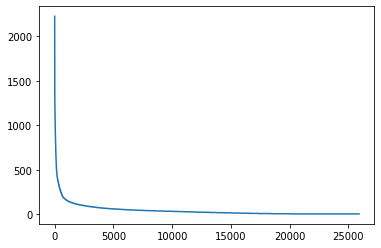

In [9]:
transaction_counts = transactions['TransactionId'].value_counts().to_numpy()
print('There are', len(transaction_counts), 'unique transactions\n')
print('Here are the counts of transactions ordered from largest to smallest')
print(transaction_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(transaction_counts) 
plt.show()

We will need to remove transactions that only included a single item

In [11]:
minimum_order_size = 2
order_group = transactions.loc[:, ['TransactionId', 'ItemCode']].groupby('TransactionId').count()
 
multi_order = order_group[(order_group.ItemCode >= minimum_order_size)].count()
single_order = order_group[(order_group.ItemCode < minimum_order_size)].count()
 
print('Orders with at least',minimum_order_size,'products:',multi_order['ItemCode'])
print('Orders with less than',minimum_order_size,'products:',single_order['ItemCode'])
 
# We can capture the list of mutiple product orders with this:
order_filter = order_group[(order_group.ItemCode >= minimum_order_size)].index.tolist()

Orders with at least 2 products: 25900
Orders with less than 2 products: 0


Well it looks like this entire dataset has transactions with multiple products. No need to filter out transactions with only a single.

In [13]:
transactions.to_pickle(path='../data/interim/vipin20/transactions.gz')

In [14]:
transaction_list = list(np.sort(transactions.TransactionId.unique())) # Get our unique customers
item_list = list(transactions.ItemCode.unique()) # Get our unique products that were purchased
quantity_list = list(transactions.NumberOfItemsPurchased) # All of our purchases

cols = transactions.TransactionId.astype(CategoricalDtype(categories=transaction_list, ordered=True)).cat.codes 
# Get the associated row indices
rows = transactions.ItemCode.astype(CategoricalDtype(categories=item_list, ordered=True)).cat.codes 
# Get the associated column indices
purchases_sparse = scipy.sparse.csr_matrix((quantity_list, (rows, cols)), shape=(len(item_list), len(transaction_list)))

In [15]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.41153632142772